In [315]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import math
import math
import pydicom
import nibabel as nib
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import dosma
from dosma.data_io.dicom_io import DicomReader
from dosma.data_io.med_volume import MedicalVolume
from dosma.data_io.nifti_io import NiftiReader

sys.path.append('/home/vanveen/ConvDecoder/')
from include.mri_helpers import generate_t2_map

In [649]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

def create_background_class(vol):
    ''' given a binary 4d volume s.t. fourth dimn corresponds to # classes
        create an additional slice in the fourth dimn, making the background a class 
        e.g. (512,512,160,6) --> (512,512,160,7), where [:,:,:,0] has 1 if background '''
    
    assert vol.ndim == 4 and vol.shape[-1] == 6
    
    # binary 3d mask if that voxel doesn't have a segmentation label
    background = (~np.max(vol, axis=-1)).astype('int')
    
    # insert 3d background mask as first 3d slice in output vol
    return np.insert(vol, obj=0, values=background, axis=-1)

def get_t2_val(t2_map, mask, key_val):
    ''' given a t2_map, a 3d mask w vals on [0..6], int key_val on [0..6]
        return the average t2 value across the tissue corresponding to key_val '''
    
    assert(t2_map.shape == mask.shape)
    
    if len(np.unique(mask)) == 2 and mask.max() == 1:
        raise ValueError('make sure this isnt a binary mask')
    
    # tissue-specific binary mask s.t. 1 if voxel=key_val, 0 otw
    mask_tissue = np.where(mask==key_val, 1, 0)
    
    masked_t2 = t2_map * mask_tissue
    masked_t2 = masked_t2[masked_t2 != 0] # remove irrelevant zero entries
    
    return np.mean(masked_t2)

def count_vals(arr):
    '''given array, return frequency counts of unique values '''
    
    y = np.bincount(arr.flatten())
    ii = np.nonzero(y)[0]
    
    return np.vstack((ii,y[ii])).T

def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(10,10))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')
        
def plot_list_t2(arr_list, title_list, clim=None):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        plt.imshow(arr_list[idx][0], cmap='gray', clim=None, aspect=1./SF)
        ii = plt.imshow(arr_list[idx][1], cmap='jet', alpha=0.3, clim=None, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=.5, pad=.1)
        plt.colorbar(ii, cax=cax)
        ax.axis('off')

### overview
- i've recon'ed 20 axial slices of (512, 160). compare t2_map(recon) vs t2_map(gt) on e1, e2
    - for file_id's ['005', '006', '030', '034']

### notes
- mask is a (512, 512, 160) int array w values [0..6]
- each dcm in `/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/` alternates b/w t1, t2
    - that's why te alternates b/w [.006, .034]
    - dimn then makes sense, we have 320/2 = 160 slices of 512x512 each
    - - between slices of a scan, (tr, te) values are the same
    - note te varies if echo1 or echo2
    - across different scans, (tr, te) vary slightly. for now, just accept the constant values
    - why use te value from echo1 as default val?
- dosma code, e.g. in `qdess.py` or `med_volume.py`
    - `t2_map_wrapped = T2(t2_map_wrapped)` step is irrelevant
    - `tissue.add_quantitative_value(t2_map_wrapped)` step is irrelevant - adds the t2_map attribute to input tissue

### TODO
- build this to run over many samples (currently generating more data)
- plot this to make sure we don't have bugs
- ask why we use te value from echo1 as default val? why not te from echo2?

### load gt, mask as MedicalVolume

- nifti mask is 3d, where each voxel is on [0..6], where 0 is background
- h5 mask is 4d binary, i.e. (x,y,z,6), where a 1 corresponds to the six classes [1..6]
- i convert this into (x,y,z,7) s.t. the first 3d slice is a 1 if background
- hence doing np.argmax(_, -1) gives us a 3d mask on [0..6] with the same counts as nifti
    - note orientation of nifti masks is off

In [667]:
file_id = '030'

# indices to isolate central axial volumes per dd+ recons
IDX_SLICE_MIN = 246
IDX_SLICE_MAX = 266

### load gt, isolate central volumes

In [668]:
path_gt = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/MTR_{}/'.format(file_id)

volumes = DicomReader().load(path_gt)
echo1 = volumes[0]  # This is a MedicalVolume
echo2 = volumes[1]

e1_gt = echo1.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]
e2_gt = echo2.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]

### load dc + slice-wise normaliz'n s.t. each recon slice has same range as gt

In [669]:
path_dd = '/bmrNAS/people/dvv/out_qdess/accel_4x/echo_joint/specific_slices/'

slice_idx_list = np.arange(IDX_SLICE_MIN, IDX_SLICE_MAX)
    
vol_shape = (IDX_SLICE_MAX-IDX_SLICE_MIN, 512, 160)
e1_dc, e2_dc = np.empty(vol_shape), np.empty(vol_shape)

for idx_s, slice_idx in enumerate(slice_idx_list):

    fn_e1 = 'MTR_{}_e1_dc_slice{}.npy'.format(file_id, slice_idx)
    fn_e2 = 'MTR_{}_e2_dc_slice{}.npy'.format(file_id, slice_idx)

    e1_dc[idx_s] = np.load(path_dd + fn_e1)
    e2_dc[idx_s] = np.load(path_dd + fn_e2)
    
for idx_s in np.arange(len(e1_gt)):
    
    # get slices
    s1_dc, s1_gt = e1_dc[idx_s], e1_gt[idx_s]
    s2_dc, s2_gt = e2_dc[idx_s], e2_gt[idx_s]
    
    # apply normaliz'n
    s1_dc_rng = s1_dc.max() - s1_dc.min()
    e1_dc[idx_s] = (s1_dc - s1_dc.min()) * (s1_gt.max() / s1_dc_rng)
    s2_dc_rng = s2_dc.max() - s2_dc.min()
    e2_dc[idx_s] = (s2_dc - s2_dc.min()) * (s2_gt.max() / s2_dc_rng)

### load, orient mask

In [670]:
path_m_h5 = '/bmrNAS/people/arjun/data/qdess_knee_2020/image_files/MTR_{}.h5'.format(file_id)
path_m_nifti = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/masks/MTR_{}.nii.gz'.format(file_id)

# (512,512,160) where each value has a value from 0-6, where 0 is background
mask_nifti = NiftiReader().load(path_m_nifti)

with h5py.File(path_m_h5, "r") as f:
    mask_h5 = f["seg"][()]
mask_h5 = create_background_class(mask_h5) # (x,y,z,6) --> (x,y,z,7)
mask_h5_ = np.argmax(mask_h5, -1) 

mask = MedicalVolume(mask_h5_, mask_nifti.affine)

mask = mask.reformat(echo1.orientation)

# note: must rotate/flip before cropping
mask_ = mask.volume
mask_ = np.rot90(mask_, k=3, axes=(0,1))
mask_ = np.fliplr(mask_)

# mask w class vals [0..6]
mask_ = mask_[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :] 

# binary mask: 0 if voxel is backgound, otw 1
# used for plotting all non-background tissues
mask_bi = np.where(mask_!=0, 1, 0) 

### compute t2 maps

In [672]:
t2_map_dc, stats_dc = generate_t2_map(e1_dc, e2_dc)
t2_map_gt, stats_gt = generate_t2_map(e1_gt, e2_gt)

### compute mean t2 value for each tissue of interest

In [673]:
mask_vals = np.unique(mask_)
key_val_list = mask_vals[mask_vals != 0]

for key_val in key_val_list:
    
    t2_gt = get_t2_val(t2_map_gt, mask_, key_val=key_val)
    t2_dc = get_t2_val(t2_map_dc, mask_, key_val=key_val)
    print(key_val, t2_gt, t2_dc)

1 32.75780346820808 36.052658959537574
2 42.63374609130707 42.903157181571814


### qual comparison of t2 maps

In [ ]:
# use binary mask to filter for only relevant (non-background) voxels
t2_map_gt = mask_bi * t2_map_gt
t2_map_dc = mask_bi * t2_map_dc

t2_map_diff = abs(t2_map_dc - t2_map_gt)

### plot either gt v. dc or diff_map

In [443]:
idx = 0 # which axial slice in central volume to plot

e1_gt_, e1_dc_ = e1_gt[idx], e1_dc[idx] 
e2_gt_, e2_dc_ = e2_gt[idx], e2_dc[idx]
t2_map_gt_, t2_map_dc_, t2_map_diff_ = t2_map_gt[idx], t2_map_dc[idx], t2_map_diff[idx]

fig = plt.figure(figsize=(20,20))

# plot_list_t2([[e1_gt_, t2_map_gt_], [e1_dc_, t2_map_dc_]], 
#              title_list=['t2_map_gt overlayed on gt', \
#                          't2_map_recon overlayed on recon',])

# plt.imshow(e1_gt_, cmap='gray', aspect=1./2.56)
# plt.imshow(t2_map_diff_, cmap='jet', alpha=0.2, aspect=1./2.56)
# plt.title('abs(diff(t2_map_recon, t2_map_gt)) overlayed on gt', fontsize=32)
# plt.colorbar()
# plt.axis('off')

<Figure size 1440x1440 with 0 Axes>

# OLD

### check to see if masks align w tissue

- to get numpy array from MedicalVolume a, use a.volume

(512, 512, 160)
(512, 512, 160)
(512, 512, 160)


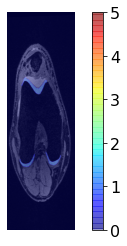

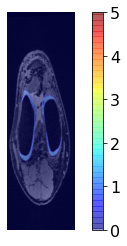

In [212]:
idx_slice_list = [50, 80, 95, 110] # slices to plot
idx_slice_list = [250, 280]

ee1 = echo1.volume
mm = mask.volume
print(mm.shape)

# added this outside loop
mm = np.rot90(mm, k=3, axes=(0,1))
mm = np.fliplr(mm)

for idx_slice in idx_slice_list:

#     e1_s = ee1[:,:,idx_slice]
#     m_s = mm[:,:,idx_slice]
    e1_s = ee1[idx_slice,:,:]
    m_s = mm[idx_slice,:,:]
    
    plt.imshow(e1_s, cmap='gray')
    plt.imshow(m_s, cmap='jet', clim=(0,5), alpha=0.4)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [626]:
# id_ = '005'
# path_mtr = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/MTR_{}/'

# ds = pydicom.dcmread(path_mtr_dir + 'I167.dcm')
# arr = ds.pixel_array

# plt.imshow(arr,cmap='gray')